In [16]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter

import math
from math import floor, ceil, log10

import json

In [2]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor <= 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_curvature_integral(best_scattering_data):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I
    smoothed_I_double_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=2, delta=np.mean(np.diff(Q_best)))
    I_double_prime_squared = smoothed_I_double_prime**2
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    return integral_val

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

# Your new functions (with dQ^2 scaling)
def calculate_slope_integral(best_scattering_data):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = 3
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Reuse distances if provided
    if D2 is None:
        # Pre-scale once to save a division in the exponent
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2          # = (Q_i-Q_j)^2 / length^2
        K = s2 * np.exp(-0.5 * D2)
    else:
        K = s2 * np.exp(-0.5 * D2 / (length*length))

    # Fast diag add, scalar/vector unified
    if np.isscalar(noise_var):
        K.ravel()[::n+1] += (noise_var + jitter)
        nv = noise_var
    else:
        nv = np.ascontiguousarray(noise_var, dtype=y.dtype)
        K.ravel()[::n+1] += nv + jitter

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    mu = y - (nv * z if not np.isscalar(nv) else nv * z)
    return mu

import numpy as np

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

# 3. EQSANS

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
count per sec: 369.75187583957
Using best dataset: Bin size = EQSANS, Time = 1800
Best data total counts: 1800.0
Using nbins = 192 for EQSANS synthetic data generation


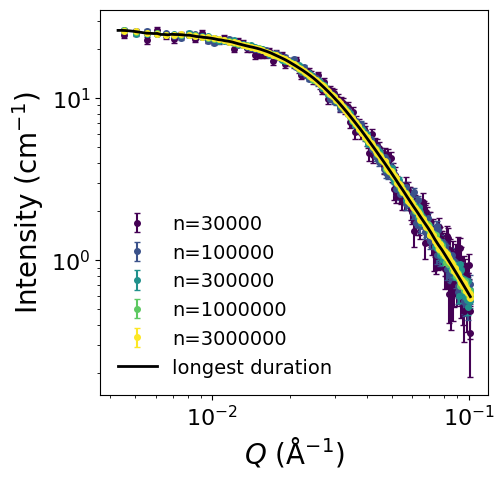

In [3]:
# Define the folder path
folder_path = '../data/EQSANS/output_23463/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '4m12a' in filename and 't4' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f't4_4m12a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
# for i_time, time_key in enumerate([sorted_time_keys[-1]]):
#     scattering_data = data['EQSANS'][collimation][time_key]
#     Q = scattering_data.Q
#     I = scattering_data.I
#     I_err = scattering_data.I_err
#     dQ = scattering_data.dQ
#     total_counts = scattering_data.total_counts

#     ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
#     print(len(Q))

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 8  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# Also filter ground truth for plotting
mask_gt = (best_data.Q < 0.2) & (best_data.Q > 0)
best_I_interpolated = interpolate_best_I(best_data, best_data.Q, window_length=17)
# create best data_interpolated
best_data_interpolated = ScatteringData(best_data.Q[mask_gt], best_I_interpolated[mask_gt], best_data.I_err[mask_gt], best_data.dQ[mask_gt])

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---

count_list = [3e4, 1e5, 3e5, 1e6, 3e6]
count_list = np.array(count_list, dtype=float)
count_list = count_list

N_MC = 16
synthetic_data_list = []
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a colormap for the count_list
cmap = cm.get_cmap('viridis', len(count_list))
norm = mcolors.Normalize(vmin=np.min(count_list), vmax=np.max(count_list))

for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    bin_size_key = 'EQSANS'
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = int(len(sd_ref.Q)*1.92)
    if i_MC == 0:
        print(f"Using nbins = {nbins} for EQSANS synthetic data generation")

    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(count_list):
        time_val = float(time_str)
        total_counts = time_val

        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data_interpolated, qgrid, window_length=5)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        if bin_size_key == 'EQSANS' and i_MC == 0:
            color = cmap(i_time)
            ax.errorbar(Q_centers, I_uniform, yerr=I_err_uniform, fmt='o', markersize=4, label=f'n={int(time_str)}', color=color, capsize=2)

# Plot the longest duration
long_duration_line, = ax.loglog(best_data.Q, best_I_interpolated, label='longest duration', color='black', linestyle='-', linewidth=2, zorder=10)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
ax.set_ylabel(r'Intensity (cm$^{-1}$)', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=16)

# Move the longest duration one to the last in legend
handles, labels = ax.get_legend_handles_labels()
# Find the index of 'longest duration'
long_idx = labels.index('longest duration')
# All other indices except long_idx
other_indices = [i for i in range(len(labels)) if i != long_idx]
# New order: all others, then long_idx
order = other_indices + [long_idx]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, fontsize=14)

# 4. EQSANS-2

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
count per sec: 90.68858578358115
Using best dataset: Bin size = EQSANS, Time = 3600
Best data total counts: 3600.0
Using nbins = 192 for EQSANS synthetic data generation


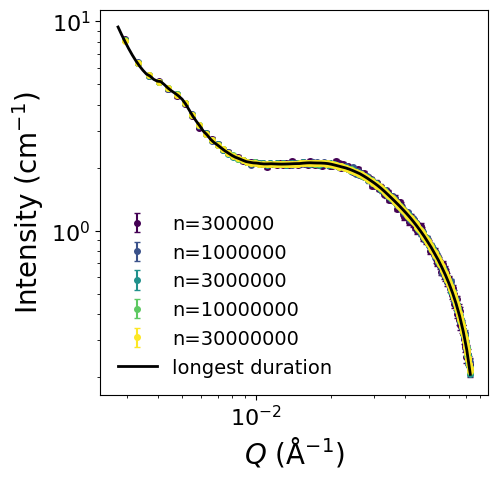

In [4]:
# Define the folder path
folder_path = '../data/EQSANS/output_22170/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'S3A' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'S3A_20C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
# for i_time, time_key in enumerate([sorted_time_keys[-1]]):
#     scattering_data = data['EQSANS'][collimation][time_key]
#     Q = scattering_data.Q
#     I = scattering_data.I
#     I_err = scattering_data.I_err
#     dQ = scattering_data.dQ
#     total_counts = scattering_data.total_counts

#     ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
#     print(len(Q))

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 8  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# Also filter ground truth for plotting
mask_gt = (best_data.Q < 0.2) & (best_data.Q > 0)
best_I_interpolated = interpolate_best_I(best_data, best_data.Q, window_length=17)
# create best data_interpolated
best_data_interpolated = ScatteringData(best_data.Q[mask_gt], best_I_interpolated[mask_gt], best_data.I_err[mask_gt], best_data.dQ[mask_gt])

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---

count_list = [3e4, 1e5, 3e5, 1e6, 3e6]
count_list = np.array(count_list, dtype=float)
count_list = count_list*10

N_MC = 16
synthetic_data_list = []
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a colormap for the count_list
cmap = cm.get_cmap('viridis', len(count_list))
norm = mcolors.Normalize(vmin=np.min(count_list), vmax=np.max(count_list))

for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    bin_size_key = 'EQSANS'
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = int(len(sd_ref.Q)*1.92)
    if i_MC == 0:
        print(f"Using nbins = {nbins} for EQSANS synthetic data generation")

    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(count_list):
        time_val = float(time_str)
        total_counts = time_val

        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data_interpolated, qgrid, window_length=5)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        if bin_size_key == 'EQSANS' and i_MC == 0:
            color = cmap(i_time)
            ax.errorbar(Q_centers, I_uniform, yerr=I_err_uniform, fmt='o', markersize=4, label=f'n={int(time_str)}', color=color, capsize=2)

# Plot the longest duration
long_duration_line, = ax.loglog(best_data.Q, best_I_interpolated, label='longest duration', color='black', linestyle='-', linewidth=2, zorder=10)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
ax.set_ylabel(r'Intensity (cm$^{-1}$)', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=16)

# Move the longest duration one to the last in legend
handles, labels = ax.get_legend_handles_labels()
# Find the index of 'longest duration'
long_idx = labels.index('longest duration')
# All other indices except long_idx
other_indices = [i for i in range(len(labels)) if i != long_idx]
# New order: all others, then long_idx
order = other_indices + [long_idx]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, fontsize=14)

# 6. EQSANS-4

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
count per sec: 6.16694009242295
Using best dataset: Bin size = EQSANS, Time = 3600
Best data total counts: 3600.0
Using nbins = 192 for EQSANS synthetic data generation


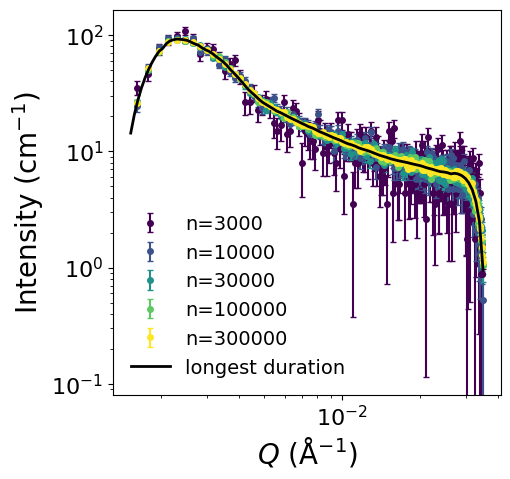

In [5]:
# Define the folder path
folder_path = '../data/EQSANS/output_22386/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'CVWLM7' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'CVWLM2_20C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
# for i_time, time_key in enumerate([sorted_time_keys[-1]]):
#     scattering_data = data['EQSANS'][collimation][time_key]
#     Q = scattering_data.Q
#     I = scattering_data.I
#     I_err = scattering_data.I_err
#     dQ = scattering_data.dQ
#     total_counts = scattering_data.total_counts

#     ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
#     print(len(Q))

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 8  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# Also filter ground truth for plotting
mask_gt = (best_data.Q < 0.2) & (best_data.Q > 0)
best_I_interpolated = interpolate_best_I(best_data, best_data.Q, window_length=17)
# create best data_interpolated
best_data_interpolated = ScatteringData(best_data.Q[mask_gt], best_I_interpolated[mask_gt], best_data.I_err[mask_gt], best_data.dQ[mask_gt])

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---

count_list = [3e4, 1e5, 3e5, 1e6, 3e6]
count_list = np.array(count_list, dtype=float)
count_list = count_list/10

N_MC = 16
synthetic_data_list = []
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a colormap for the count_list
cmap = cm.get_cmap('viridis', len(count_list))
norm = mcolors.Normalize(vmin=np.min(count_list), vmax=np.max(count_list))

for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    bin_size_key = 'EQSANS'
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = int(len(sd_ref.Q)*1.92)
    if i_MC == 0:
        print(f"Using nbins = {nbins} for EQSANS synthetic data generation")

    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(count_list):
        time_val = float(time_str)
        total_counts = time_val

        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data_interpolated, qgrid, window_length=5)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        if bin_size_key == 'EQSANS' and i_MC == 0:
            color = cmap(i_time)
            ax.errorbar(Q_centers, I_uniform, yerr=I_err_uniform, fmt='o', markersize=4, label=f'n={int(time_str)}', color=color, capsize=2)

# Plot the longest duration
long_duration_line, = ax.loglog(best_data.Q, best_I_interpolated, label='longest duration', color='black', linestyle='-', linewidth=2, zorder=10)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
ax.set_ylabel(r'Intensity (cm$^{-1}$)', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=16)

# Move the longest duration one to the last in legend
handles, labels = ax.get_legend_handles_labels()
# Find the index of 'longest duration'
long_idx = labels.index('longest duration')
# All other indices except long_idx
other_indices = [i for i in range(len(labels)) if i != long_idx]
# New order: all others, then long_idx
order = other_indices + [long_idx]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, fontsize=14)

# 2. USANS

measure_time,undefined,1e4,3e4,1e5,3e5,3e6
samples,,,,,,
sample1,UN_Sample1_det_1_unscaled.txt,UN_Sample1_1e4_det_1_unscaled.txt,UN_Sample1_3e4_det_1_unscaled.txt,UN_Sample1_1e5_det_1_unscaled.txt,UN_Sample1_3e5_det_1_unscaled.txt,NaN
sample2,UN_Sample2_det_1_unscaled.txt,UN_Sample2_1e4_det_1_unscaled.txt,UN_Sample2_3e4_det_1_unscaled.txt,UN_Sample2_1e5_det_1_unscaled.txt,UN_Sample2_3e5_det_1_unscaled.txt,NaN
sample3,UN_Sample3_det_1_unscaled.txt,UN_Sample3_1e4_det_1_unscaled.txt,UN_Sample3_3e4_det_1_unscaled.txt,UN_Sample3_1e5_det_1_unscaled.txt,UN_sample3_3e5_det_1_unscaled.txt,UN_Sample3_3e6_det_1_unscaled.txt
sample4,UN_Sample4_det_1_unscaled.txt,UN_Sample4_1e4_det_1_unscaled.txt,UN_Sample4_3e4_det_1_unscaled.txt,UN_Sample4_1e5_det_1_unscaled.txt,UN_Sample4_3e5_det_1_unscaled.txt,UN_Sample4_3e6_det_1_unscaled.txt
sample5,UN_Sample5_det_1_unscaled.txt,UN_Sample5_1e4_det_1_unscaled.txt,UN_Sample5_3e4_det_1_unscaled.txt,UN_Sample5_1e5_det_1_unscaled.txt,UN_Sample5_3e5_det_1_unscaled.txt,NaN
sample6,UN_Sample6_det_1_unscaled.txt,UN_Sample6_1e4_det_1_unscaled.txt,UN_Sample6_3e4_det_1_unscaled.txt,NaN,UN_Sample6_3e5_det_1_unscaled.txt,NaN
sample7,UN_Sample7_det_1_unscaled.txt,UN_Sample7_1e4_det_1_unscaled.txt,UN_Sample7_3e4_det_1_unscaled.txt,UN_Sample7_1e5_det_1_unscaled.txt,UN_Sample7_3e5_det_1_unscaled.txt,NaN
sample8,UN_Sample8_det_1_unscaled.txt,UN_Sample8_1e4_det_1_unscaled.txt,UN_Sample8_3e4_det_1_unscaled.txt,UN_Sample8_1e5_det_1_unscaled.txt,UN_Sample8_3e5_det_1_unscaled.txt,NaN
sample9,UN_Sample9_det_1_unscaled.txt,UN_Sample9_1e4_det_1_unscaled.txt,UN_Sample9_3e4_det_1_unscaled.txt,UN_Sample9_1e5_det_1_unscaled.txt,UN_sample9_3e5_det_1_unscaled.txt,NaN


64
64
64
64
64
64


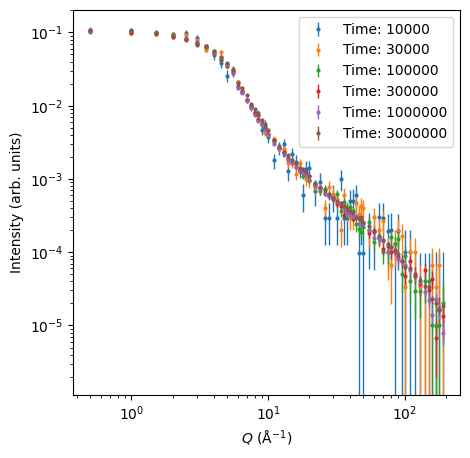

In [18]:
import os
import pandas as pd
import re

file_path = "../data/USANS/32871/"
sample_files = [f for f in os.listdir(file_path) if 'sample' in f.lower()]
labels = ["unscaled", "lb", "lbs"]
filtered_files = [f for f in sample_files if labels[0] in f]
# Prepare lists to store extracted info
measure_times = []
samples = []

for fname in filtered_files:
    # Extract measure time (e.g., 1e4, 3e5, etc.)
    match_time = re.search(r'_(\d+e\d+)_', fname)
    measure_times.append(match_time.group(1) if match_time else None)
    # Extract samples (e.g., Sample1, Sample2, etc.)
    match_samples = re.search(r'(Sample\d+)', fname, re.IGNORECASE)
    samples.append(match_samples.group(1) if match_samples else None)

# Create DataFrame
df_info = pd.DataFrame({
    'filename': filtered_files,
    'measure_time': measure_times,
    'samples': samples
})

# Normalize sample names to lowercase for merging
df_info['samples'] = df_info['samples'].str.lower()
df_info['measure_time'] = df_info['measure_time'].fillna('undefined')
df_pivot = df_info.pivot_table(index='samples', columns='measure_time', values='filename', aggfunc='first')

# Sort columns by measurement time, keeping 'undefined' first
def time_key(x):
    if x == 'undefined':
        return -float('inf')
    try:
        return float(x.replace('e', 'E'))
    except:
        return float('inf')

sorted_columns = sorted(df_pivot.columns, key=time_key)
df_pivot = df_pivot.reindex(columns=sorted_columns)

display(df_pivot)

sample4_files = df_info[df_info['samples'].str.lower() == 'sample4']['filename']
sample4_data_list = [
    np.loadtxt(os.path.join(file_path, fname), skiprows=0, delimiter=',', usecols=(0,1,2))
    for fname in sample4_files
]

sample4_time_list = []
for fname in sample4_files:
    match = re.search(r'_(\d+e\d+)_', fname)
    if match:
        sample4_time_list.append(float(match.group(1)))
    else:
        sample4_time_list.append(np.nan)

sample4_time_list = [1e6 if np.isnan(t) else t for t in sample4_time_list]

# Combine times and data, sort by time, then unpack
sorted_items = sorted(zip(sample4_time_list, sample4_data_list), key=lambda x: (np.isnan(x[0]), x[0]))
sample4_time_list_sorted, sample4_data_list_sorted = zip(*sorted_items)

# Convert back to list
sample4_time_list = list(sample4_time_list_sorted)
sample4_data_list = list(sample4_data_list_sorted)

data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For USANS, we use bin='USANS' and collimation='-', time is represented by total counts

# Store Sample4 data into the data structure using measurement time as key
for i, arr in enumerate(sample4_data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = np.zeros_like(Q)  # USANS files may not have dQ; set to zeros or estimate if available
    total_counts = sample4_time_list[i]
    # Use bin='USANS', collimation='-', time=str(int(total_counts))
    data['USANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # USANS uses '-' for collimation
sorted_time_keys = sorted(data['USANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['USANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

Using best dataset: Bin size = USANS, Time = 3000000
Best data total counts: 3000000.0
Using nbins = 192 for USANS synthetic data generation


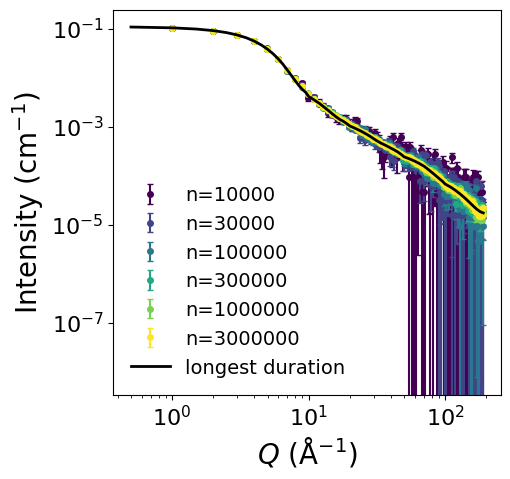

In [25]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'USANS'  # manually selected
best_time_str = str(int(sample4_time_list[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)


count_list = [float(k) for k in sorted_time_keys]
# Create a colormap for the count_list
cmap = cm.get_cmap('viridis', len(count_list))
norm = mcolors.Normalize(vmin=np.min(count_list), vmax=np.max(count_list))

N_MC = 1
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'USANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = int(len(sd_ref.Q)*3)
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(sorted_time_keys):
        time_val = float(time_str)
        total_counts = time_val  # time already represents total counts for USANS

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=7)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        # Plot only for the first bin size
        if i_MC == 0:
            color = cmap(i_time)
            ax.errorbar(Q_centers, I_uniform, yerr=I_err_uniform, fmt='o', markersize=4, label=f'n={int(time_str)}', color=color, capsize=2)

# Plot the longest duration
long_duration_line, = ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=15), label='longest duration', color='black', linestyle='-', linewidth=2, zorder=10)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
ax.set_ylabel(r'Intensity (cm$^{-1}$)', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=16)

# Move the longest duration one to the last in legend
handles, labels = ax.get_legend_handles_labels()
# Find the index of 'longest duration'
long_idx = labels.index('longest duration')
# All other indices except long_idx
other_indices = [i for i in range(len(labels)) if i != long_idx]
# New order: all others, then long_idx
order = other_indices + [long_idx]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, fontsize=14)